In [1]:
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(tidyr))
suppressPackageStartupMessages(library(tibble))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(stringr))
library(parallel)
library(reshape2)
library(ggsci)
library(rstatix)
library(ggpubr)
library(ggplot2) 
library(GGally) 
library(pheatmap)



Attaching package: ‘reshape2’


The following object is masked from ‘package:tidyr’:

    smiths



Attaching package: ‘rstatix’


The following object is masked from ‘package:stats’:

    filter


Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2



In [2]:

is_dark_color <- function(hex) {
  rgb <- col2rgb(hex)
  
  luminance <- 0.299 * rgb[1,] + 0.587 * rgb[2,] + 0.114 * rgb[3,]
  if(luminance < 128){
  return('white')
  } else {return('black')}
}

In [3]:
color_annotation<-read.csv('../Color_hex_codes/Cell_Type_Color_Annotation_and_Order.csv')
color_annotation$label<-gsub(' cell','',color_annotation$label)
color_vector <- setNames(color_annotation$color, color_annotation$label)

# Read composite score

In [4]:
df<-read.csv('/home//jupyter/BRI_Figures_Final_V2/Figure2/04_CompositeScore/BRI_CompositeScore_Down.csv') %>% 
filter(sample.visitName=='Flu Year 1 Day 0')

In [5]:
unique(df$celltype)

[1] "CM CD4 T cell"             "CM CD8 T cell"            
[3] "Core naive CD4 T cell"     "Core naive CD8 T cell"    
[5] "GZMB- CD27- EM CD4 T cell" "GZMB- CD27+ EM CD4 T cell"
[7] "GZMK+ CD27+ EM CD8 T cell" "Naive CD4 Treg"

In [6]:
df$celltype<-gsub(' cell','',df$celltype)
celltype_order <- c("Core naive CD8 T", 
                    "CM CD8 T", 
                    "GZMK+ CD27+ EM CD8 T",
                    "Naive CD4 Treg",
                    "Core naive CD4 T",
                    "CM CD4 T",
                    "GZMB- CD27- EM CD4 T",
                    "GZMB- CD27+ EM CD4 T")
df$celltype <- factor(df$celltype,levels=celltype_order)


# Plotting

In [7]:
STAT_res <- df[c('composite_score_sum_scaled_mean','celltype','cohort.cohortGuid')] %>%
    dplyr::group_by(celltype) %>%
    wilcox_test(composite_score_sum_scaled_mean ~ cohort.cohortGuid, paired = FALSE) %>%
    adjust_pvalue(method = 'BH') %>%
    add_xy_position() %>%
    add_significance() %>%mutate(p.adj = format(p.adj, scientific = TRUE, digits = 3))

In [8]:
df <- df %>% dplyr::mutate(`Age Group` = case_when(
  cohort.cohortGuid == "BR1" ~ "Young",
  cohort.cohortGuid == "BR2" ~ "Older",
  TRUE ~ NA_character_
))
df$`Age Group`<-factor(df$`Age Group`,levels=c("Young","Older"))

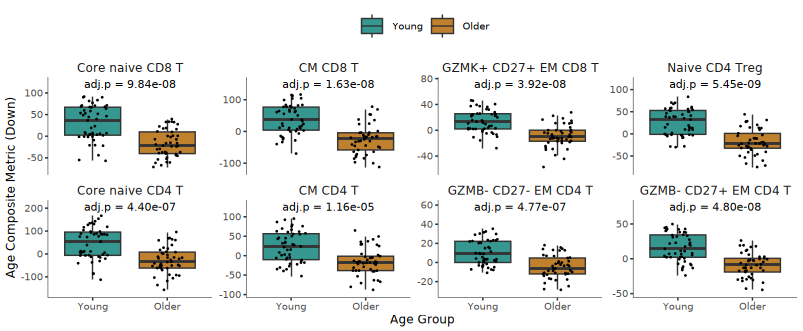

In [9]:
options(repr.plot.width = 170/25.4, repr.plot.height =  70/25.4)

p <- ggplot(df ,
              aes(x = `Age Group`, y = composite_score_sum_scaled_mean)) +
    geom_boxplot( lwd=0.3, outlier.shape = NA,aes(fill = `Age Group`))+
    geom_point(aes(y = composite_score_sum_scaled_mean), 
               position = position_jitter(width = 0.2), color="black", size=0.5, stroke=0) +
    facet_wrap(~ celltype, scales = 'free_y', ncol = 4) +   
    stat_pvalue_manual(STAT_res, size=2.2,  bracket.size=0,
                       label = "adj.p = {p.adj}", 
                       tip.length = 0) +
    theme_classic(base_size = 7) +
    scale_fill_manual(values = c("Older" = '#bf812d', "Young" = '#35978f')) +
    scale_y_continuous(limits = c(NA, NA), expand = expansion(mult = c(0.1, 0.15)))+ylab('Age Composite Metric (Down)')+ 
guides(shape = guide_legend(override.aes = list(size = 0.5)))+
    theme(axis.line = element_line(colour = "black", linewidth = 0.1),
          legend.position = "top",
          legend.title = element_blank(),
          panel.grid.major = element_blank(),
          panel.grid.minor = element_blank(),
          panel.border = element_blank(),
          panel.background = element_blank(),
          strip.background = element_rect(linewidth = 0),
          axis.title.x = element_text(margin = margin(t = 2)),
         strip.text = element_text(size = 7))
p


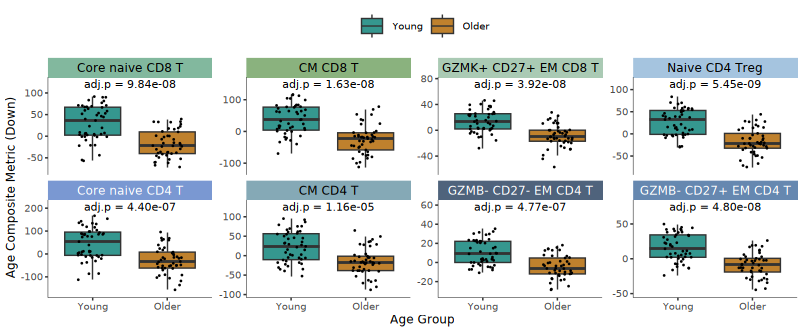

In [11]:
plot <- ggplot_gtable(ggplot_build(p))

strips <- which(grepl('strip-', plot$layout$name))
strip_labels <- sapply(strips, function(i) {
  plot$grobs[[i]]$grobs[[1]]$children[[2]]$children[[1]]$label
})
#strip_labels<-gsub(' cell','',strip_labels)

pal <- color_vector[strip_labels]
text_color <- sapply(color_vector[strip_labels], is_dark_color)

strip_names <- plot$layout$name[strips]


for (i in seq_along(strips)) {
  strip_name <- strip_names[i]

  
  k <- which(grepl('rect', plot$grobs[[strips[i]]]$grobs[[1]]$childrenOrder))
  l <- which(grepl('titleGrob', plot$grobs[[strips[i]]]$grobs[[1]]$childrenOrder))
  
  adjusted_color <- adjustcolor(pal[i], alpha.f = 0.8)
  
  plot$grobs[[strips[i]]]$grobs[[1]]$children[[k]]$gp$fill <- adjusted_color
  plot$grobs[[strips[i]]]$grobs[[1]]$children[[l]]$children[[1]]$gp$col <- text_color[i]
}

plot(plot)
ggsave('FigureC.pdf',plot,width = 165/25.4, height =  75/25.4)